## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [4]:
import glob

import numpy as np
import pandas as pd
import scipy as sp
import scipy.io
import scipy.signal

from matplotlib import pyplot as plt

In [5]:
def process_ppg(ppg, low_bpm, high_bpm, fs):
    """
    Process the PPG Signal

    Args:
        ppg: PPG Signal
        freqs: a numpy array of frequency bins
        ftt_len: length of ppg
        low_bpm: minimum bpm
        high_bpm: maximum bpm
    Returns:
        Processed PPG Signal and Max PPG Frequency

    """
    ppg = BandpassFilter(signal=ppg)
    ftt_len = max(len(ppg), 2046)
    freqs = np.fft.rfftfreq(ftt_len, 1 / fs)

    ppg_fft = np.abs(np.fft.rfft(ppg, ftt_len))
    pks = sp.signal.find_peaks(ppg_fft, height=2000, distance=1500)[0]
    ppg_mag = freqs[np.argsort(ppg_fft)[-3:][::-1]]

    return ppg_fft, ppg_mag, freqs
def process_acc(acc, low_bpm, high_bpm, fs):
    """
    Process the ACC Signal

    Args:
        accx: (np.array) x-channel of the accelerometer.
        accy: (np.array) y-channel of the accelerometer.
        accz: (np.array) z-channel of the accelerometer.
        freqs: a numpy array of frequency bins
        ftt_len: length of acc
        low_bpm: minimum bpm
        high_bpm: maximum bpm
    Returns:
        Processed ACC Signal and Max ACC Frequency
    """

    ftt_len = max(len(acc), 2046)
    freqs = np.fft.rfftfreq(ftt_len, 1 / fs)

    acc = BandpassFilter(signal=acc)

    acc_fft = np.abs(np.fft.rfft(acc, ftt_len))
    acc_mag = freqs[np.argmax(acc_fft)]

    return acc_fft, acc_mag

In [6]:
def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def RunPulseRateAlgorithm(data_fl, ref_fl):
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    ref_bpm = sp.io.loadmat(ref_fl)['BPM0']
    
    # Compute pulse rate estimates and estimation confidence.
    acc = np.sqrt(accx**2 + accy**2 + accz**2)
    low_bpm, high_bpm = 40, 240
    errors, confidences = [], []

    for i in range(round((ppg.shape[0] / fs - 8) / 2)):
        ppg_win = ppg[i*2*fs:(8*fs+i*2*fs)]
        acc_win = acc[i*2*fs:(8*fs+i*2*fs)]
        ppg_fft, ppg_mag, freqs = process_ppg(ppg_win, low_bpm, high_bpm, fs=fs)
        acc_fft, acc_mag = process_acc(acc_win, low_bpm, high_bpm, fs=fs)
        if ppg_mag[0]==acc_mag:
            curr_bpm = ppg_mag[0] * 60
        else:
            curr_bpm = ppg_mag[1] * 60
        
        true_bpm = ref_bpm[i].item()
        
        error = np.mean(np.abs(true_bpm-curr_bpm))
        errors.append(error)
        
        window_f = 5 / 60
        
        fund_freq_window = (freqs > curr_bpm/60 - window_f) & \
                            (freqs < curr_bpm/60 + window_f)
        
        ppg_power = np.sum(ppg_fft[fund_freq_window])
        total_power = np.sum(ppg_mag)
        confidence = ppg_power / total_power
        confidences.append(confidence)

    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    #errors, confidence = np.ones(100), np.ones(100)  # Dummy placeholders. Remove
    return errors, confidence

def BandpassFilter(signal, fs=125):
    lowPass = 50/60
    highPass = 240/60
    b, a = sp.signal.butter(3, (lowPass, highPass), btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)

In [7]:
#Evaluate()

In [8]:
fs = 125
data_files, ref_files = LoadTroikaDataset()

In [9]:
print(len(data_files))
print(len(ref_files))

12
12


In [10]:
data_files

['./datasets/troika/training_data/DATA_01_TYPE01.mat',
 './datasets/troika/training_data/DATA_02_TYPE02.mat',
 './datasets/troika/training_data/DATA_03_TYPE02.mat',
 './datasets/troika/training_data/DATA_04_TYPE01.mat',
 './datasets/troika/training_data/DATA_04_TYPE02.mat',
 './datasets/troika/training_data/DATA_05_TYPE02.mat',
 './datasets/troika/training_data/DATA_06_TYPE02.mat',
 './datasets/troika/training_data/DATA_07_TYPE02.mat',
 './datasets/troika/training_data/DATA_08_TYPE02.mat',
 './datasets/troika/training_data/DATA_10_TYPE02.mat',
 './datasets/troika/training_data/DATA_11_TYPE02.mat',
 './datasets/troika/training_data/DATA_12_TYPE02.mat']

In [11]:
ref_files

['./datasets/troika/training_data/REF_01_TYPE01.mat',
 './datasets/troika/training_data/REF_02_TYPE02.mat',
 './datasets/troika/training_data/REF_03_TYPE02.mat',
 './datasets/troika/training_data/REF_04_TYPE01.mat',
 './datasets/troika/training_data/REF_04_TYPE02.mat',
 './datasets/troika/training_data/REF_05_TYPE02.mat',
 './datasets/troika/training_data/REF_06_TYPE02.mat',
 './datasets/troika/training_data/REF_07_TYPE02.mat',
 './datasets/troika/training_data/REF_08_TYPE02.mat',
 './datasets/troika/training_data/REF_10_TYPE02.mat',
 './datasets/troika/training_data/REF_11_TYPE02.mat',
 './datasets/troika/training_data/REF_12_TYPE02.mat']

In [12]:
ref0 = sp.io.loadmat(ref_files[0])
print(len(ref0))

4


In [13]:
ref0.keys()

dict_keys(['__header__', '__version__', '__globals__', 'BPM0'])

In [14]:
print(ref0['__header__'])
print(ref0['__version__'])
print(ref0['__globals__'])

b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Aug 12 01:00:33 2014'
1.0
[]


In [15]:
len(ref0['BPM0'])

148

In [16]:
ppg0, accx0, accy0, accz0 = LoadTroikaDataFile(data_files[0])

In [17]:
print(len(ppg0))
ppg0

37937


array([   4. ,    6. ,    3. , ...,   86. ,  104. ,  118.5])

In [18]:
print(len(accx0))
accx0

37937


array([-0.0702, -0.0702, -0.0546, ...,  0.4134,  0.4134,  0.4134])

In [19]:
print(len(accy0))
accy0

37937


array([ 0.3432,  0.3588,  0.3666, ..., -0.2808, -0.273 , -0.273 ])

In [20]:
print(len(accz0))
accz0

37937


array([ 0.9594,  0.9438,  0.936 , ...,  0.7254,  0.7176,  0.7254])

In [21]:
def plot_signal(signal, filtered_signal, fs):
    T = len(signal)/fs
    ts = np.arange(len(signal))/fs
   
    plt.figure(1)
    plt.figure(figsize=(16,4))
    plt.title('Raw Signal')
    plt.plot(ts, signal)    

    plt.figure(2)
    plt.figure(figsize=(16,4))
    plt.plot(ts, filtered_signal)
    plt.title('Filtered Signal')

    plt.figure(3)
    plt.figure(figsize=(16,4))
    plt.plot(np.fft.rfftfreq(len(signal), 1/fs), np.abs(np.fft.rfft(signal)))
    plt.title('Fourier Transform')
    
    plt.figure(4)
    plt.figure(figsize=(16,6))
    plt.title('Spectrogram - Raw Signal')
    plt.specgram(signal, Fs=fs, NFFT=250, noverlap=125, xextent=((0, T)))
    plt.xlabel('Time (sec)')
    plt.ylabel('Frequency (Hz)')

    plt.figure(5)
    plt.figure(figsize=(16,6))
    plt.title('Spectrogram - Filtered Signal')
    plt.specgram(filtered_signal, Fs=fs, NFFT=250, noverlap=125, xextent=((0, T)))
    plt.xlabel('Time (sec)')
    plt.ylabel('Frequency (Hz)')

In [22]:
def plot_fourier(signal, filtered_signal, fs):
    T = len(signal)/fs
    ts = np.arange(len(signal))/fs

    freq = np.fft.rfftfreq(len(signal), 1/fs)
    fft = np.fft.rfft(signal)

    plt.figure(1)
    plt.figure(figsize=(16,4))
    plt.plot(np.fft.rfftfreq(len(signal), 1/fs), np.abs(np.fft.rfft(signal)))
    plt.title('Fourier Transform')
    
    return fft, freq

In [23]:
def plot_ppg_peaks(signal,):
    fs=125
    T = len(signal)/fs
    ts = np.arange(len(signal))/fs
    signal = BandpassFilter(signal, fs=fs)
    
    peaks = sp.signal.find_peaks(signal)[0]
    plt.figure(figsize=(16,6))
    plt.plot(ts, signal)
    plt.plot(ts[peaks], signal[peaks], 'r.', ms=5)
    return peaks


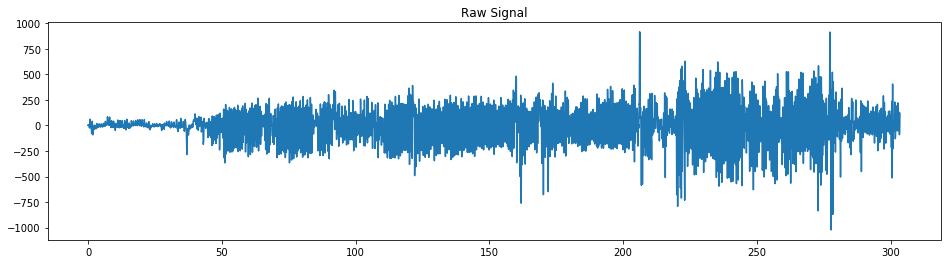

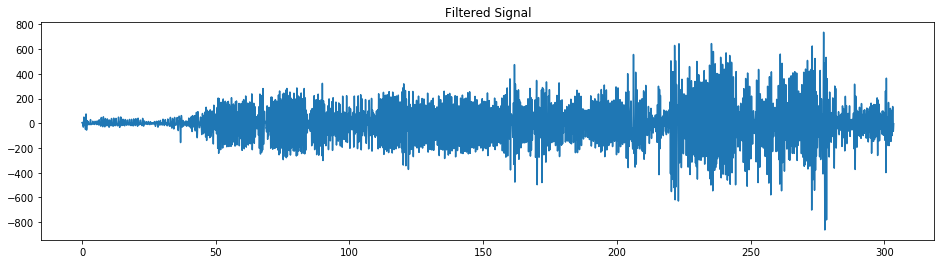

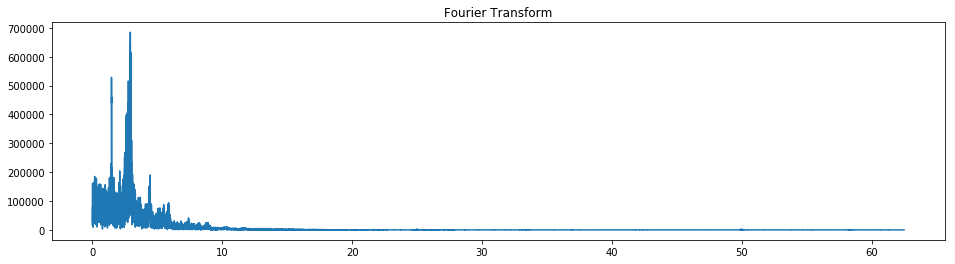

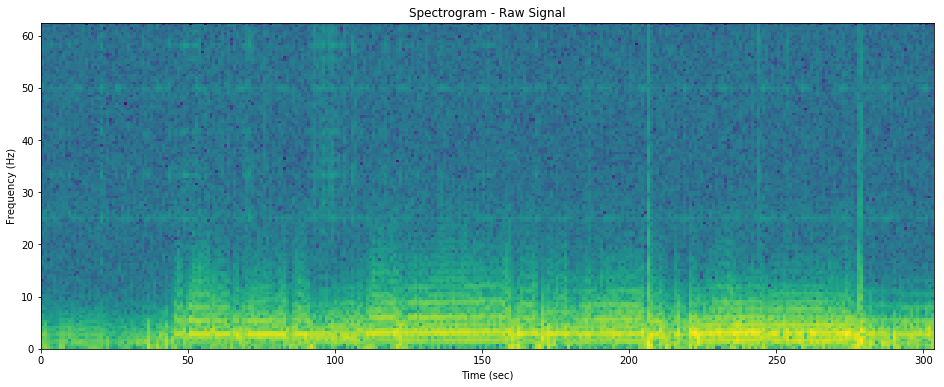

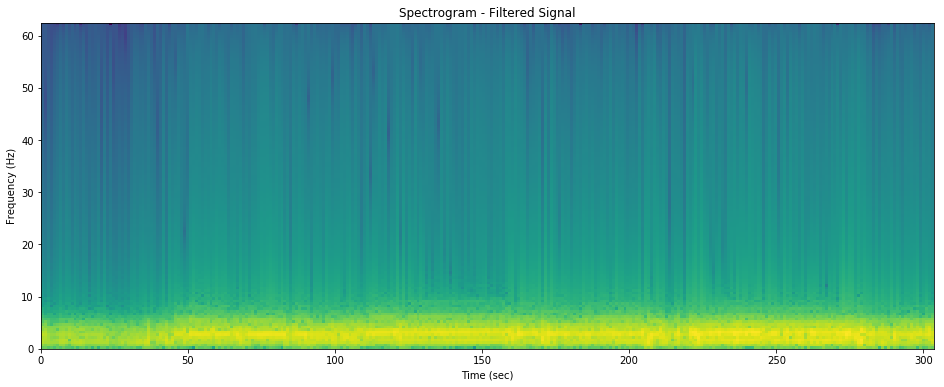

In [24]:
filtered_sig = BandpassFilter(ppg0, fs=fs)
plot_signal(ppg0, filtered_sig, fs=125)

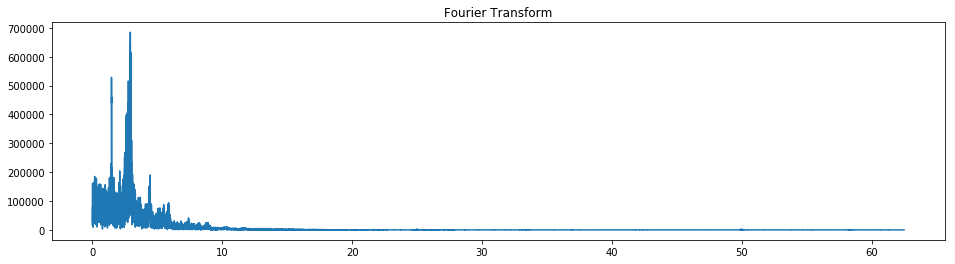

In [25]:
fft, freq = plot_fourier(ppg0, filtered_sig, fs=125)

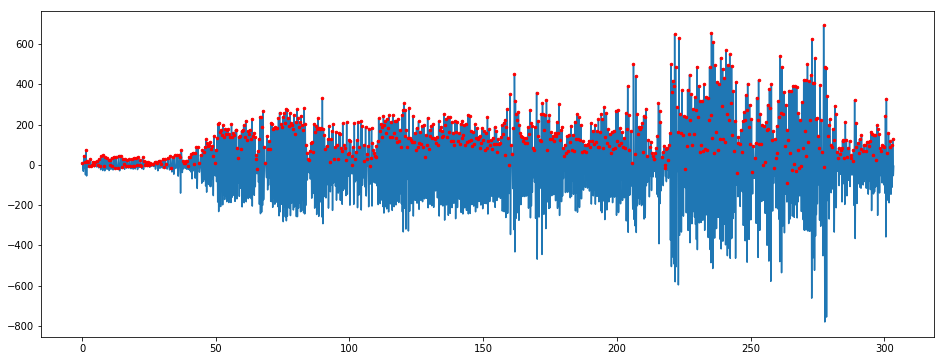

In [26]:
pks = plot_ppg_peaks(filtered_sig)

In [27]:
len(pks)

811

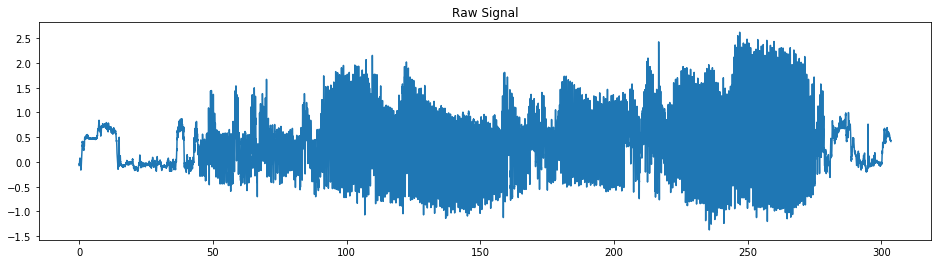

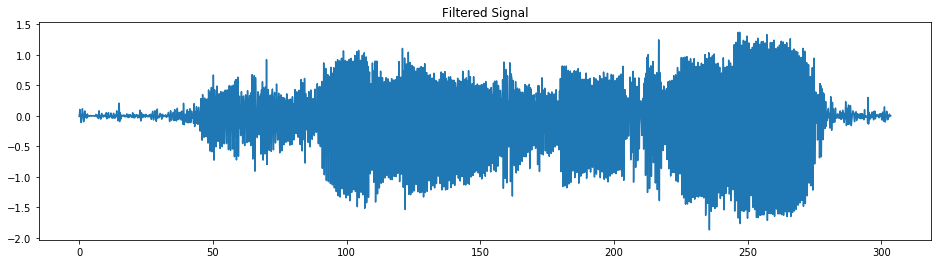

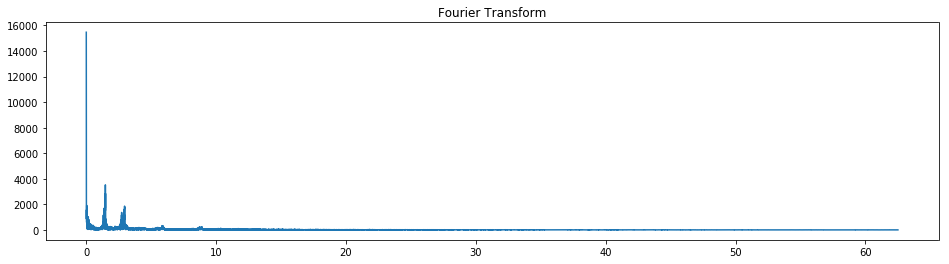

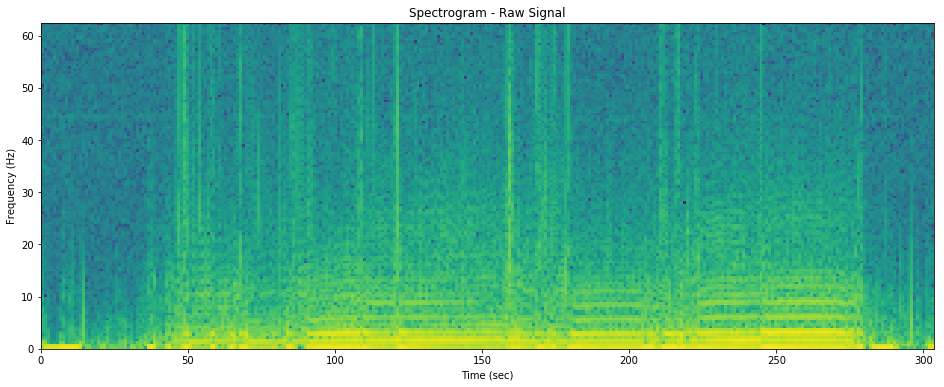

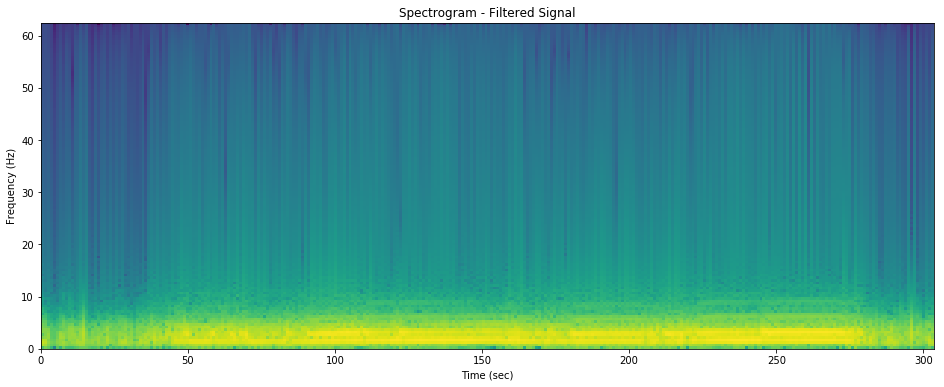

In [28]:
filtered_sig = BandpassFilter(accx0, fs=fs)
plot_signal(accx0, filtered_sig, fs=125)

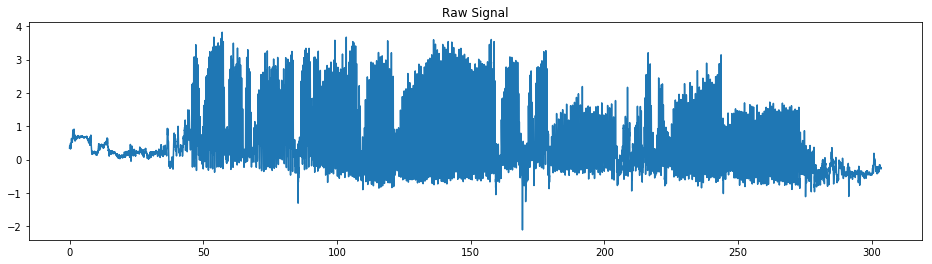

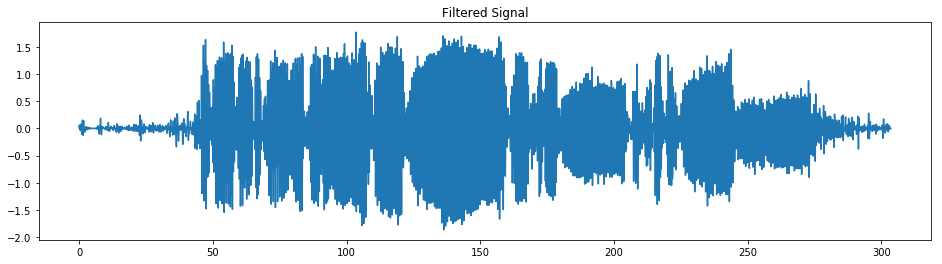

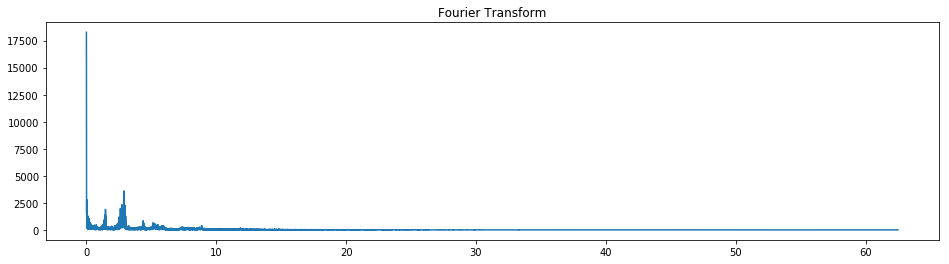

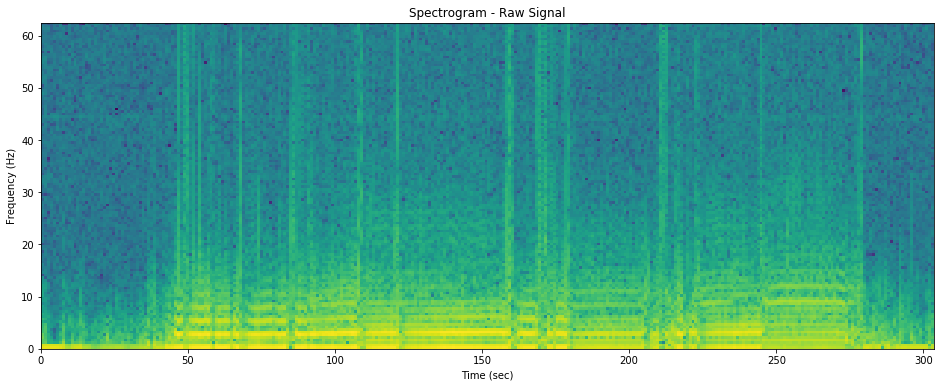

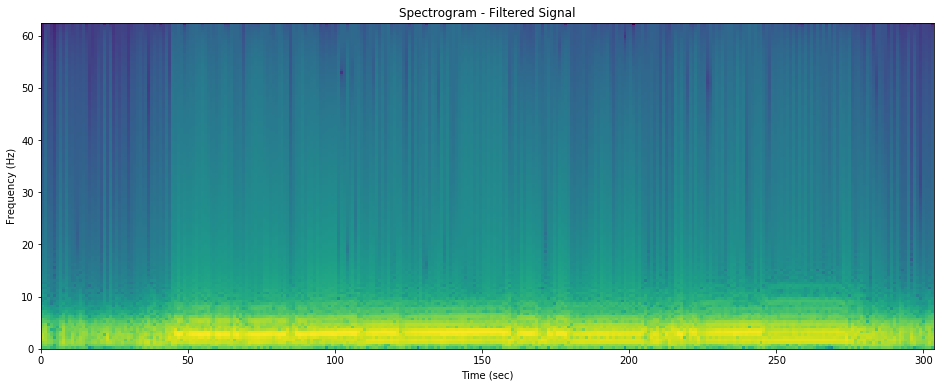

In [29]:
filtered_sig = BandpassFilter(accy0, fs=fs)
plot_signal(accy0, filtered_sig, fs=125)

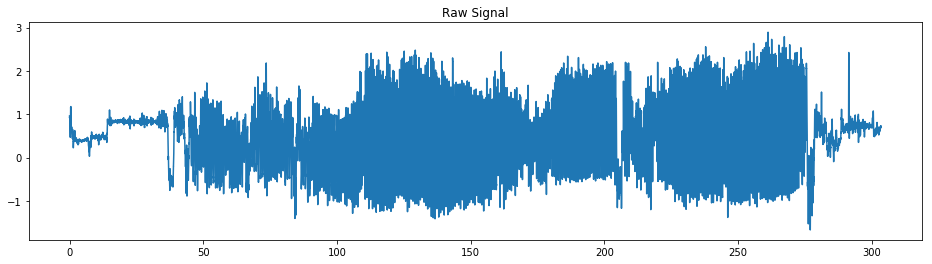

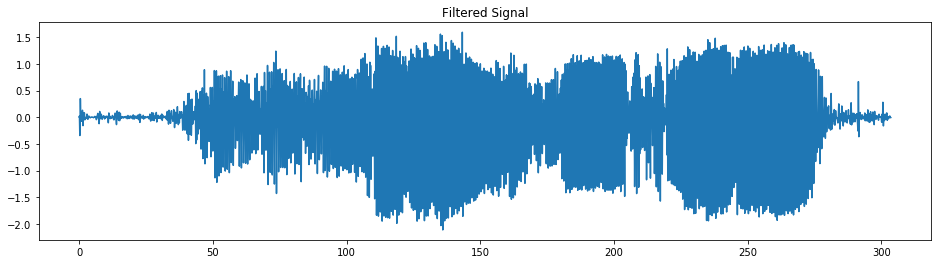

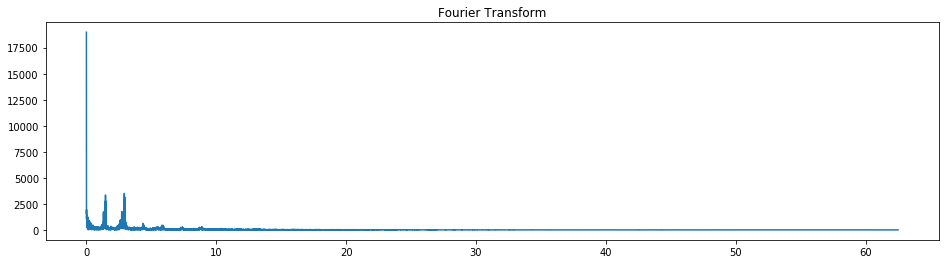

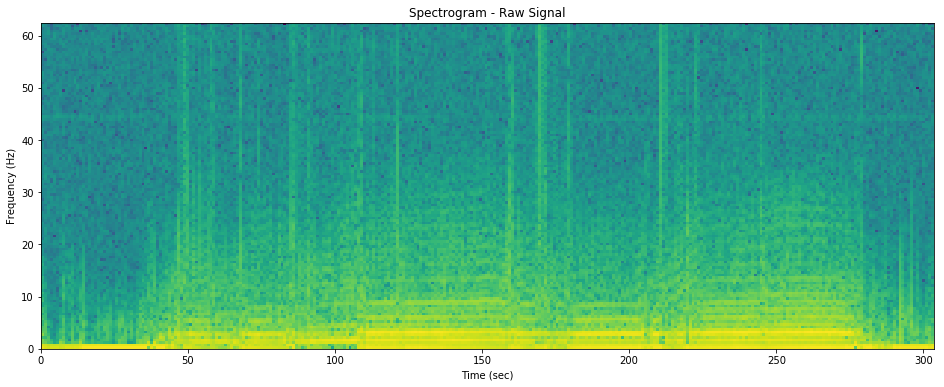

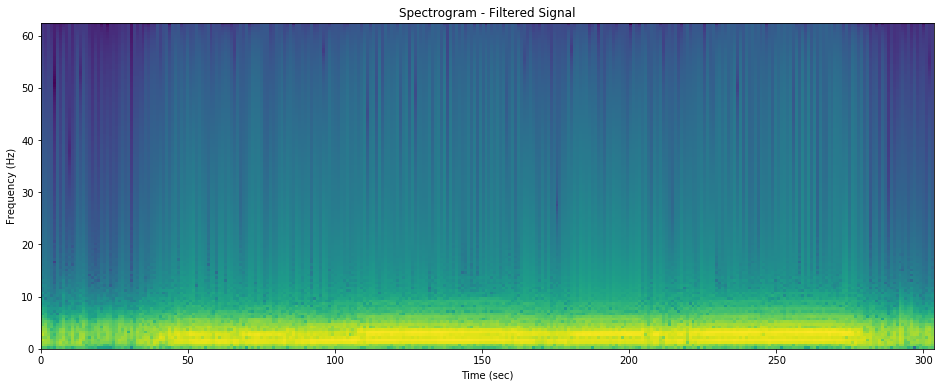

In [30]:
filtered_sig = BandpassFilter(accz0, fs=fs)
plot_signal(accz0, filtered_sig, fs=125)

In [31]:
ppg6, accx6, accy6, accz6 = LoadTroikaDataFile(data_files[6])
ref6 = sp.io.loadmat(ref_files[6])

In [32]:
print(len(ppg6))
print(len(accx6))
print(len(accy6))
print(len(accz6))

38373
38373
38373
38373


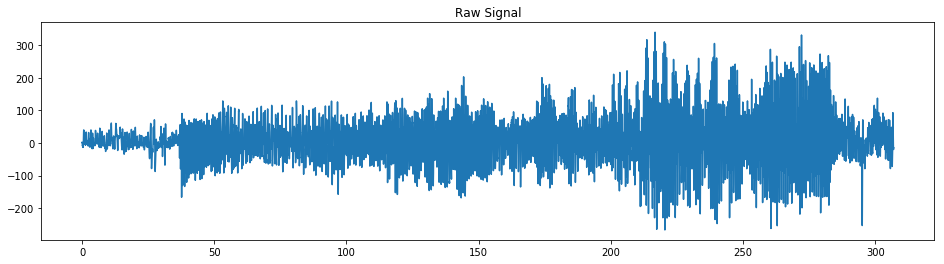

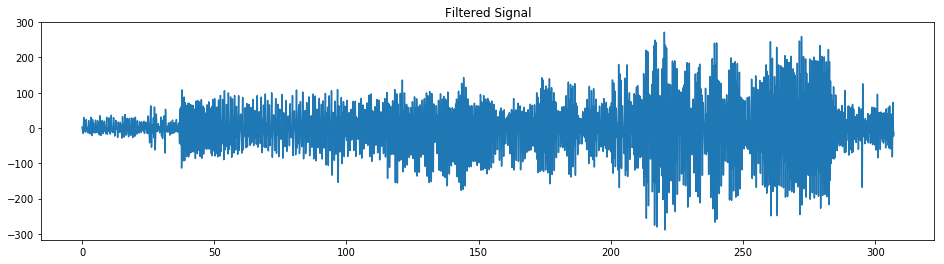

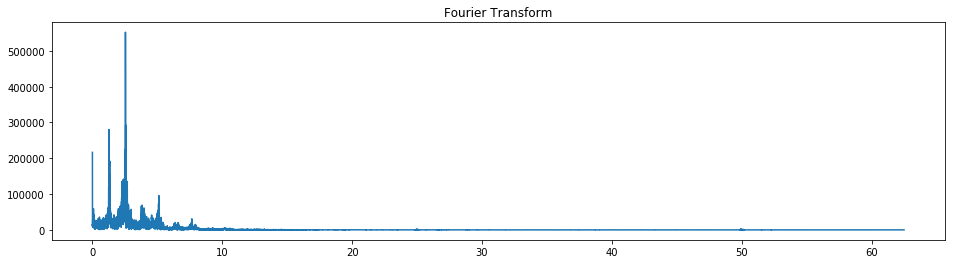

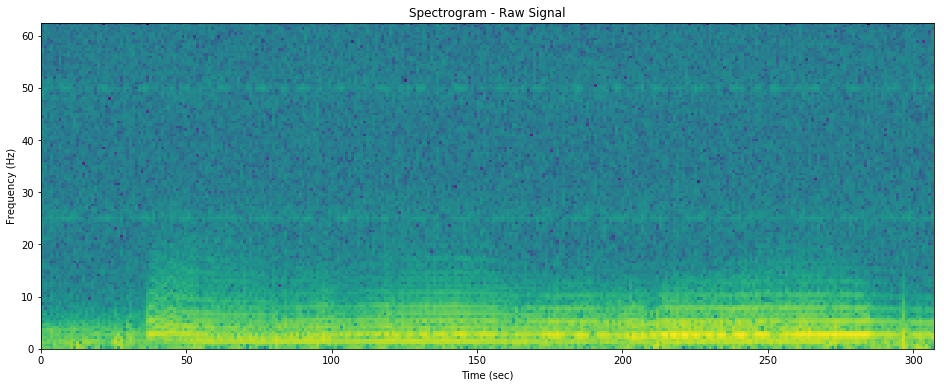

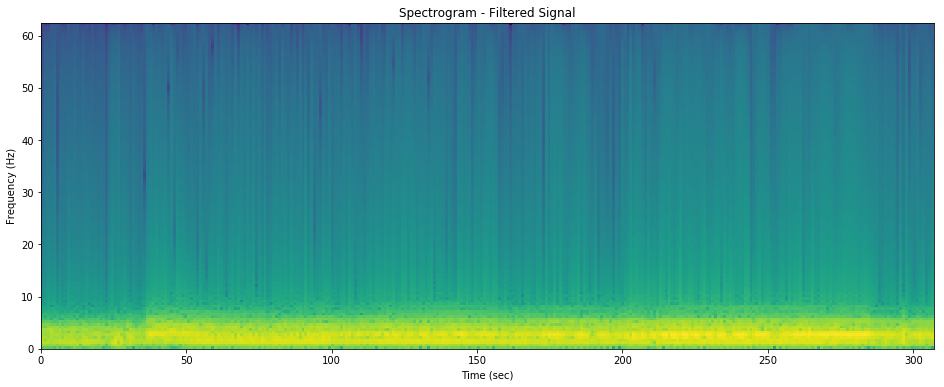

In [33]:
filtered_sig = BandpassFilter(ppg6, fs=fs)
plot_signal(ppg6, filtered_sig, fs=125)

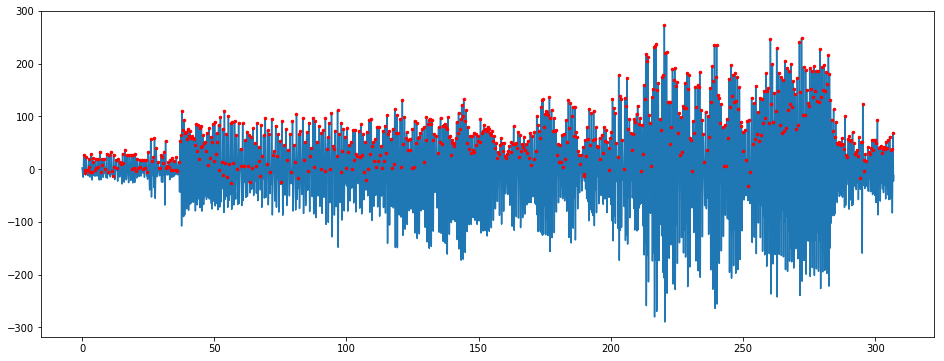

In [34]:
pks = plot_ppg_peaks(filtered_sig)

In [35]:
len(pks)

741

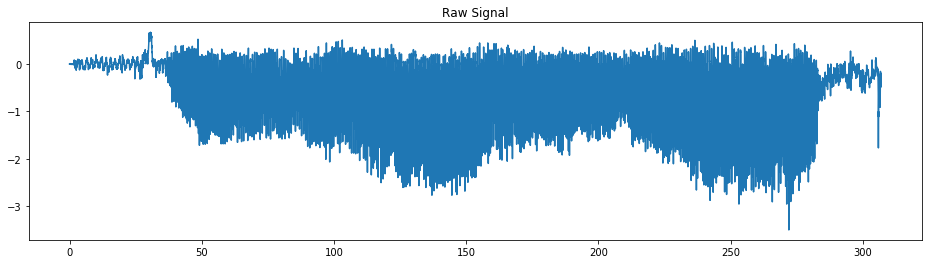

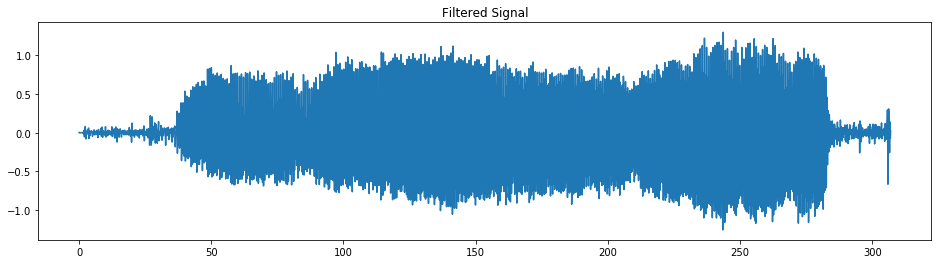

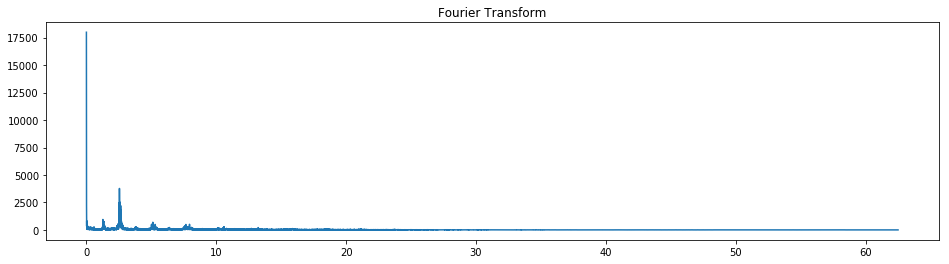

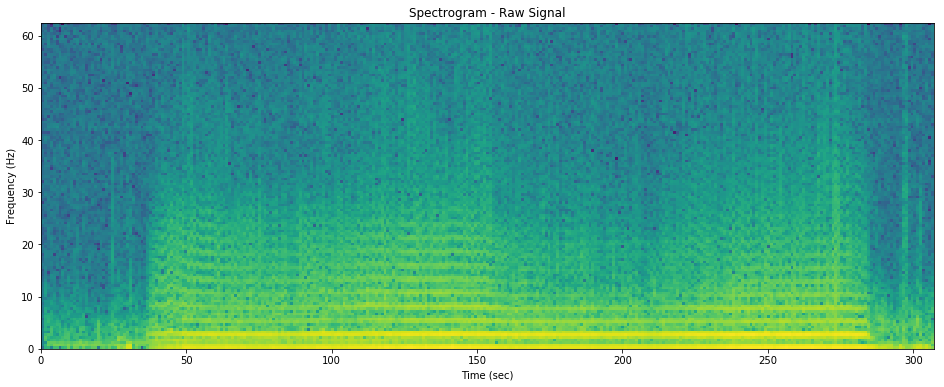

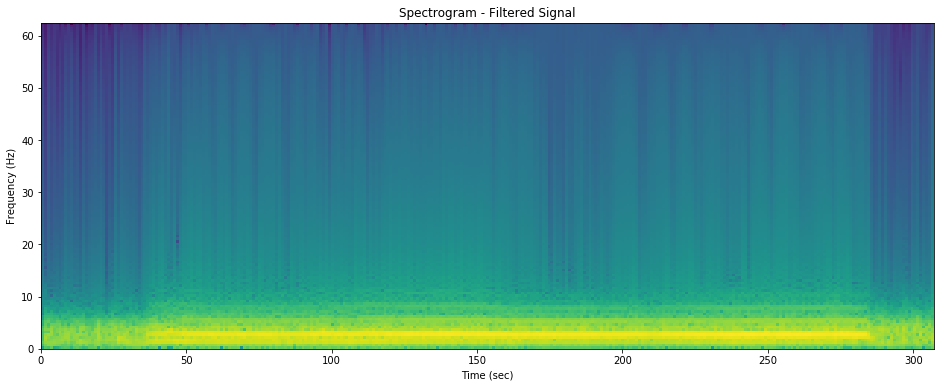

In [36]:
filtered_sig = BandpassFilter(accx6, fs=fs)
plot_signal(accx6, filtered_sig, fs=125)

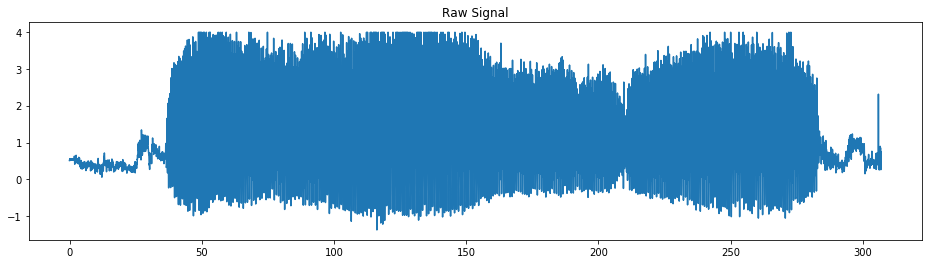

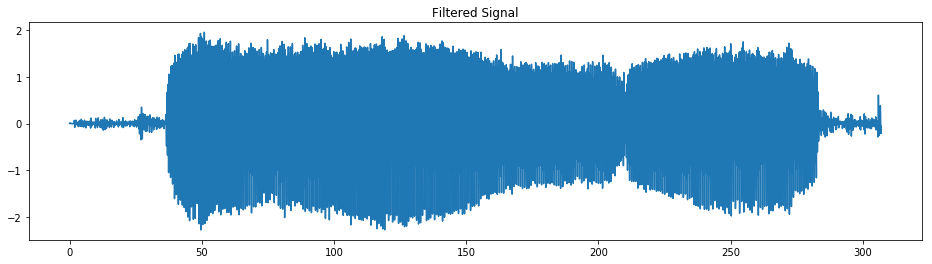

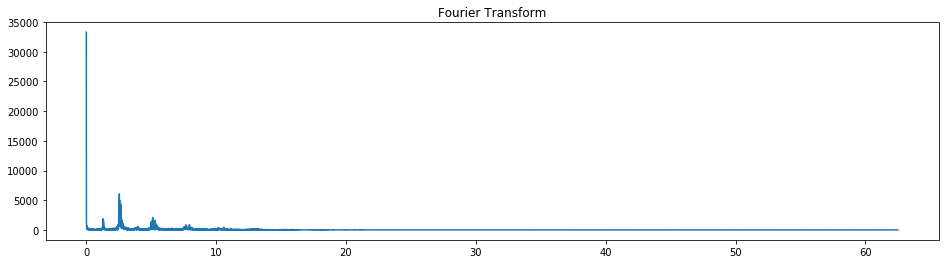

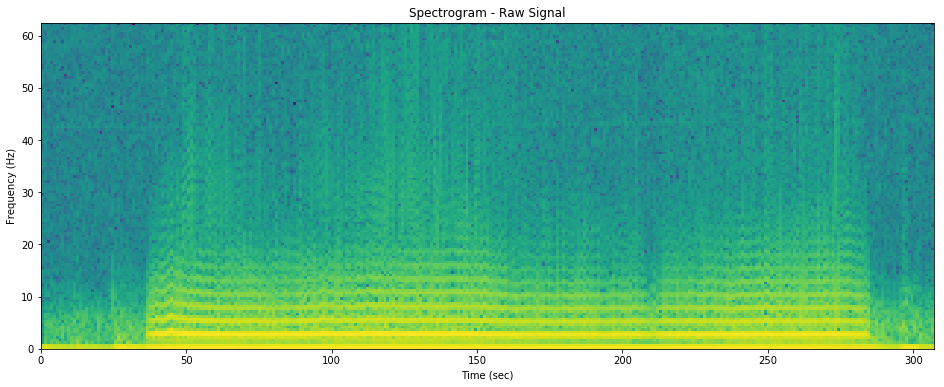

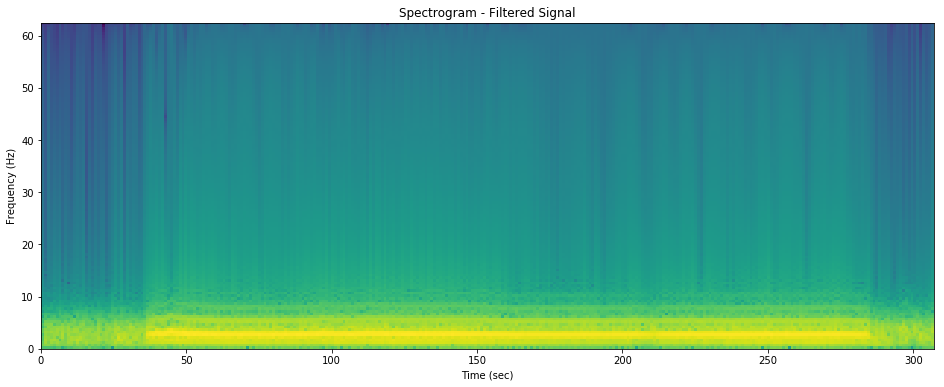

In [37]:
filtered_sig = BandpassFilter(accy6, fs=fs)
plot_signal(accy6, filtered_sig, fs=125)

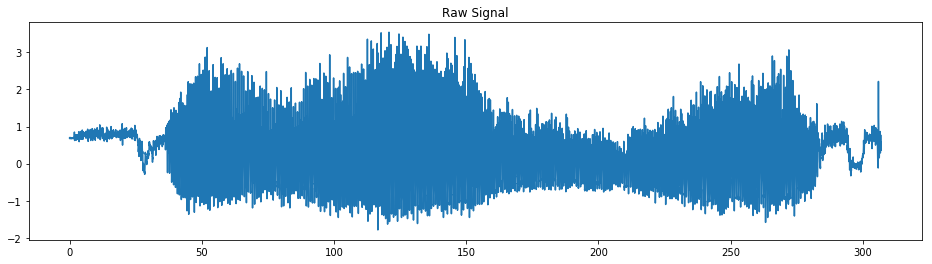

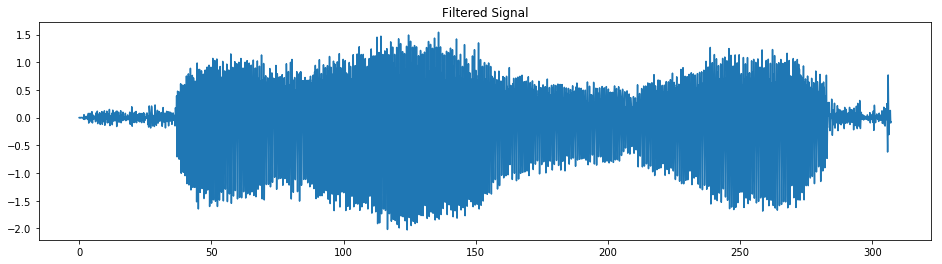

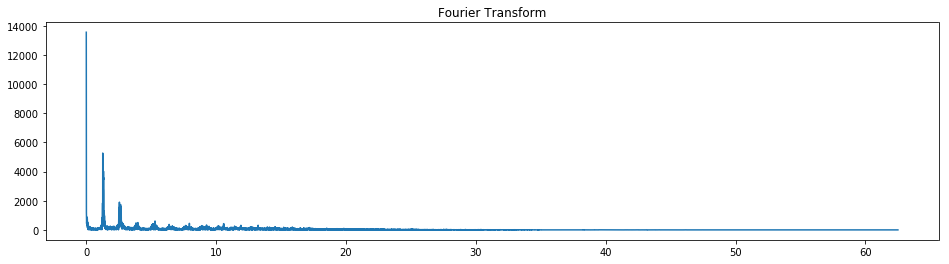

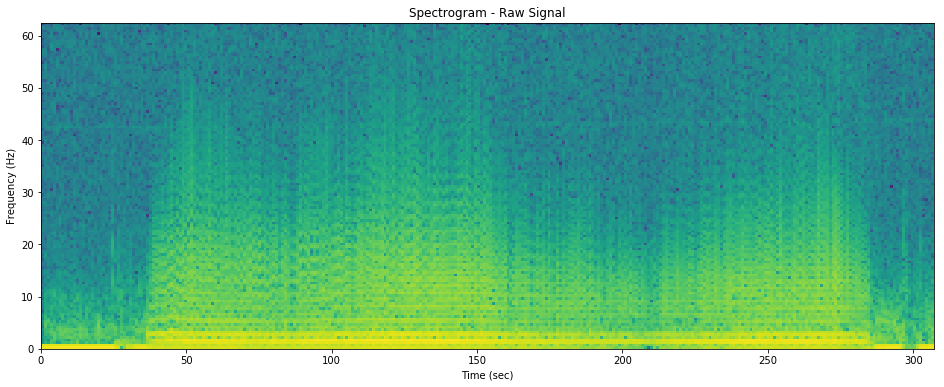

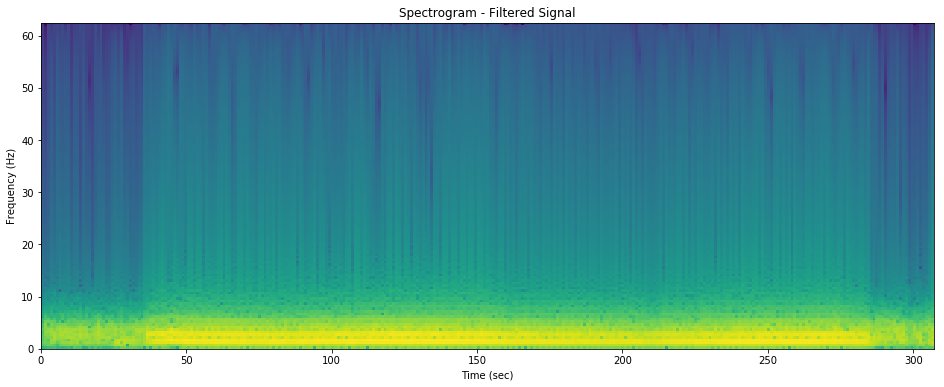

In [38]:
filtered_sig = BandpassFilter(accz6, fs=fs)
plot_signal(accz6, filtered_sig, fs=125)

In [39]:
def plot_acc_signal(accx, accy, accz):
    T = len(accx)/fs
    ts = np.arange(len(accx))/fs

    accx = BandpassFilter(accx)
    accy = BandpassFilter(accy)
    accz = BandpassFilter(accz)   
    
    plt.figure(figsize=(12,6))
    plt.clf()
    plt.plot(ts, accx, label='x')
    plt.plot(ts, accy, label='y')
    plt.plot(ts, accz, label='z')
    plt.legend()

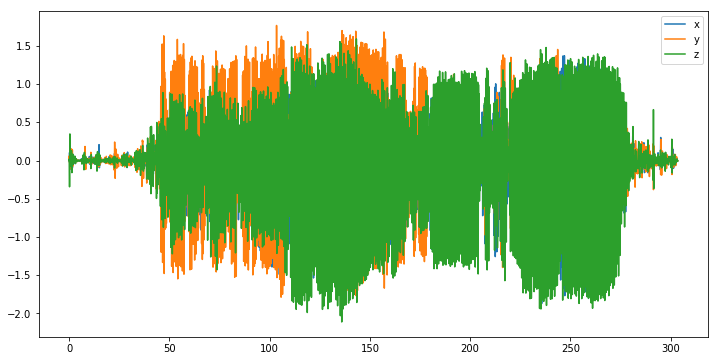

In [40]:
plot_acc_signal(accx0, accy0, accz0)

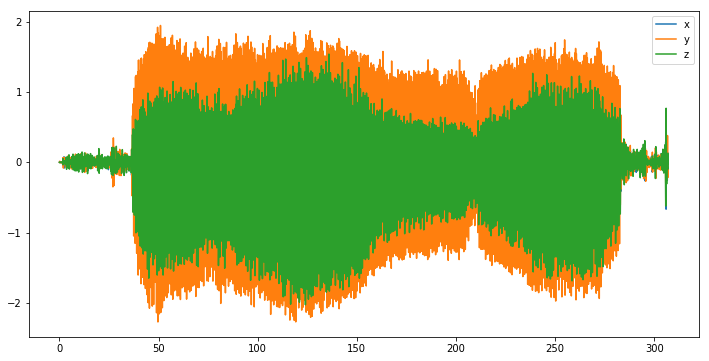

In [41]:
plot_acc_signal(accx6, accy6, accz6)

In [42]:
def plot_acc_segments(accx, accy, accz):
    T = len(accx)/fs
    ts = np.arange(len(accx))/fs

    accx = BandpassFilter(accx)
    accy = BandpassFilter(accy)
    accz = BandpassFilter(accz)   
    

    plt.figure(figsize=(10,6))
    plt.clf()
    plt.plot(ts[1000:4000], accx[1000:4000], label='x')
    plt.plot(ts[1000:4000], accy[1000:4000], label='y')
    plt.plot(ts[1000:4000], accz[1000:4000], label='z')
    plt.legend()

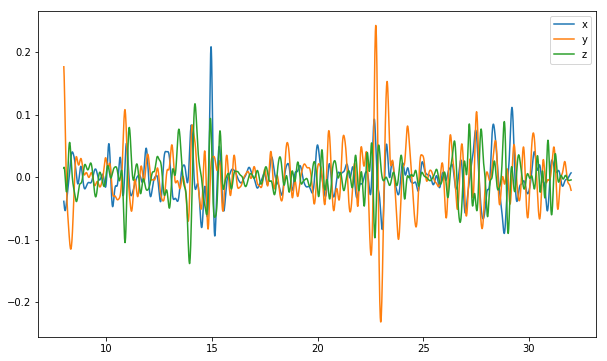

In [43]:
plot_acc_segments(accx0, accy0, accz0)

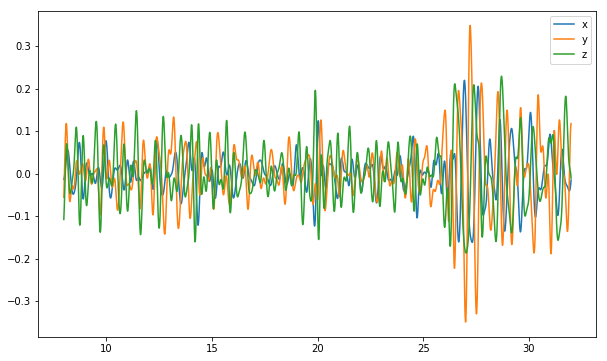

In [44]:
plot_acc_segments(accx6, accy6, accz6)

In [45]:
def plot_acc_mag( accx, accy, accz):
    T = len(accx)/fs
    ts = np.arange(len(accx))/fs
    accx = BandpassFilter(accx)
    accy = BandpassFilter(accy)
    accz = BandpassFilter(accz)
    acc_mag = np.sqrt(accx**2 + (accy - np.mean(accy))**2 + accz**2)
    #acc_mag = np.sqrt(accx**2 + accy**2 + accz**2)

    plt.figure(figsize=(10,6))
    plt.plot(ts, acc_mag, label='acc')
    plt.legend()

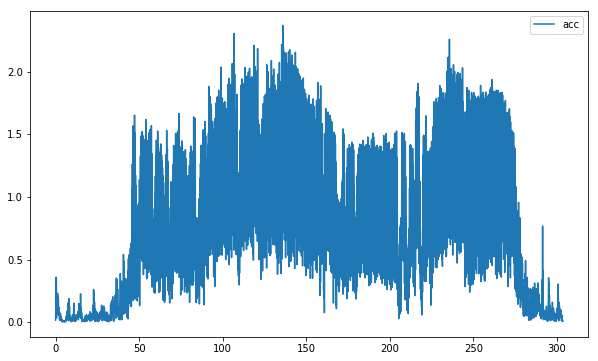

In [46]:
plot_acc_mag(accx0, accy0, accz0)

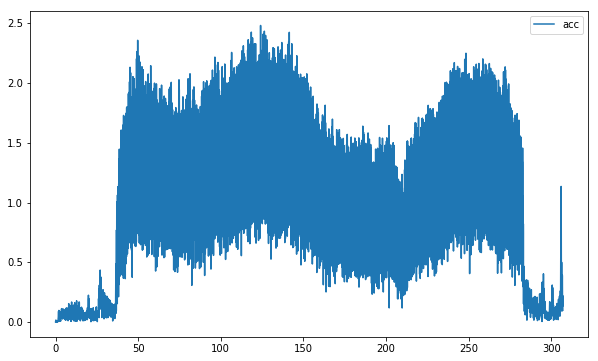

In [47]:
plot_acc_mag(accx6, accy6, accz6)

In [48]:
# def featurize(ppg, accx, accy, accz):
#     fs = 125
#     T = len(ppg)/fs/60
#     signal =  BandpassFilter(ppg)
# 
#     accx = BandpassFilter(accx)
#     accy = BandpassFilter(accy)
#     accz = BandpassFilter(accz)    
# 
#     # L2-Norms of acc
#     l2_acc = np.sqrt(accx**2 + (accy - np.mean(accy))**2 + accz**2)
# 
#     plt.figure(figsize=(10,6))
#     ppg_spec, ppg_freqs, t1, _ = plt.specgram(signal, NFFT= 8*fs, Fs=fs, noverlap= 6*fs, xextent= [0, T])
#     acc_spec, acc_freqs, t2, _ = plt.specgram(l2_acc, NFFT= 8*fs, Fs=fs , noverlap= 6*fs, xextent= [0, T])
# 
#     # max frequency for ppg as a feature
#     ppg_peaks = []
#     for i in range(len(t1)):
#         peak_p = np.argmax(ppg_spec[i:])
#         peak_a = np.argmax(acc_spec[i:])
#         ppg_peaks.append(peak_p)
# 
#     # max frequency for L2 norm of acc
#     acc_peaks = []
#     for i in range(len(t1)):
#         peak = np.argmax(acc_spec[i:])
#         acc_peaks.append(peak)
# 
#     return ppg_spec, ppg_freqs, ppg_peaks, acc_spec, acc_freqs, acc_peaks, t1, t2

In [49]:
def getpks(signal, fs):
    signal =  BandpassFilter(signal)
    freqs= np.fft.rfftfreq(len(signal), 1/fs)
    fourier= np.abs(np.fft.rfft(signal))
    pks = sp.signal.find_peaks(fourier)[0]
    
    Columns = ['Peak_Index', 'Freqs', 'Fourier_Peaks', 'BPM']    
    data = pd.DataFrame(columns = Columns)
    data['Peak_Index'] = pks
    data['Freqs'] = freqs[pks]
    data['Fourier_Peaks'] = fourier[pks]
    data['BPM'] = data['Freqs']*60
    return data, fourier

In [300]:
def find_bpm(ppg_freq, acc_freq, est_bpm=75):
    bpms = ppg_freq.copy()
    bpms['BPM_Diff'] = abs(bpms['BPM'] - est_bpm)
    
    #print(bpms)

    
    #if (ppg_freq['Freqs'][0] == acc_freq['Freqs'][0]):
    #    l1 = np.array(ppg_freq['Freqs'][0])
    #    print(l1)
    #   bpms = bpms[bpms['Freqs'][1:]]
    

    #l1 = []    
    #l1 = np.array(ppg_freq['Freqs'])
    #l2 = np.array(acc_freq['Freqs'])
    #l3 = [x for x in l1 if x not in l2]
    #print(l3)
    #bpms = bpms[bpms['Freqs'].isin(l3)]
    bpms = bpms[(bpms['BPM'] > 60) & (bpms['BPM'] < 190)]   
    bpms = bpms.sort_values(by='BPM_Diff').reset_index(drop=True)
    #print(bpms)
    bpm = bpms['BPM'][0]

    return bpm

In [301]:
signal = BandpassFilter(ppg0)
accx = BandpassFilter(accx0)
accy = BandpassFilter(accy0)
accz = BandpassFilter(accz0)

T = len(signal)/fs
#l2_acc = np.sqrt(accx**2 + (accy - np.mean(accy))**2 + accz**2)
l2_acc = np.sqrt(accx**2 + accy**2 + accz**2)
stft = []

ppg_seg = signal[17500:18500]
ppg_data, ppg_fourier = getpks(ppg_seg, fs)

acc_seg = l2_acc[17500:18500]
acc_data, acc_fourier = getpks(acc_seg, fs)


(0, 100)

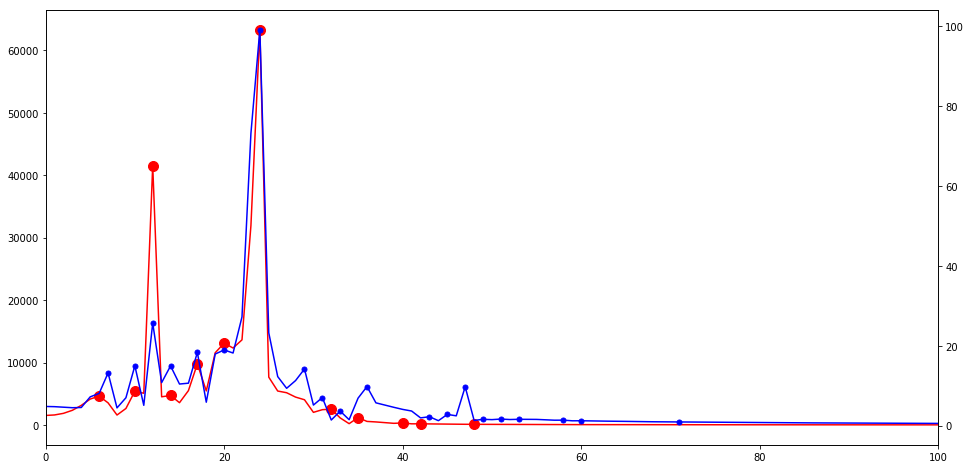

In [302]:
plt.figure(figsize=(16,8))
plt.plot(ppg_fourier , "r", label='ppg')
plt.plot(ppg_data['Peak_Index'], ppg_fourier[ppg_data['Peak_Index']],  "r.", ms=20, label='ppg')
plt.twinx()
plt.plot(acc_fourier , "b",  label='acc')
plt.plot(acc_data['Peak_Index'], acc_fourier[acc_data['Peak_Index']],  "b.", ms=10, label='ppg')
plt.xlim(0, 100)

In [303]:
ppg = ppg_data.sort_values(by='Fourier_Peaks', ascending=False).reset_index(drop=True)

In [304]:
ppg

,Peak_Index,Freqs,Fourier_Peaks,BPM
0,24,3.000,63302.412374,180.0
1,12,1.500,41556.748771,90.0
2,20,2.500,13123.714607,150.0
3,17,2.125,9797.014631,127.5
4,10,1.250,5422.043362,75.0
5,14,1.750,4744.990384,105.0
6,6,0.750,4640.818382,45.0
7,32,4.000,2555.580762,240.0
8,35,4.375,1200.127205,262.5
9,40,5.000,342.180904,300.0


In [305]:
acc = acc_data.sort_values(by='Fourier_Peaks', ascending=False).reset_index(drop=True)

In [306]:
acc

,Peak_Index,Freqs,Fourier_Peaks,BPM
0,24,3.000,99.181872,180.0
1,12,1.500,25.692856,90.0
2,20,2.500,18.960147,150.0
3,17,2.125,18.340023,127.5
4,10,1.250,14.978661,75.0
5,14,1.750,14.959442,105.0
6,29,3.625,14.186716,217.5
7,7,0.875,13.197917,52.5
8,36,4.500,9.781291,270.0
9,47,5.875,9.736652,352.5


In [307]:
x = find_bpm(ppg, acc, est_bpm=75)

In [308]:
x

75.0

In [309]:

window_len = 1000
window_shift = 250
errors, confidences = [], []

signal = BandpassFilter(ppg0)
accx = BandpassFilter(accx0)
accy = BandpassFilter(accy0)
accz = BandpassFilter(accz0)

T = len(signal)/fs
l2_acc = np.sqrt(accx**2 + (accy - np.mean(accy))**2 + accz**2)
freq = np.fft.rfftfreq(window_len, 1/fs)
calculated_bpm = []
n = 0
for i in range(0, len(signal)-window_len, window_shift):
    ppg_seg = signal[i:i + window_len]
    ppg_data, ppg_fourier = getpks(ppg_seg,fs)
    ppg = ppg_data.sort_values(by='Fourier_Peaks', ascending=False).reset_index(drop=True)
    
    acc_seg = l2_acc[i:i + window_len]
    acc_data, acc_fourier = getpks(acc_seg,fs)
    acc = acc_data.sort_values(by='Fourier_Peaks', ascending=False).reset_index(drop=True)
    
    if len(calculated_bpm) > 1:
        bpm = find_bpm(ppg, acc, calculated_bpm[len(calculated_bpm)-1])
        print(i, i + window_len, calculated_bpm[len(calculated_bpm)-1], bpm)
    else:
        bpm = find_bpm(ppg, acc, est_bpm=75)
        print(i, i + window_len, 75, bpm)
    
    n += 1
    calculated_bpm.append(bpm)

0 1000 75 75.0
250 1250 75 75.0
500 1500 75.0 75.0
750 1750 75.0 75.0
1000 2000 75.0 75.0
1250 2250 75.0 75.0
1500 2500 75.0 75.0
1750 2750 75.0 75.0
2000 3000 75.0 75.0
2250 3250 75.0 75.0
2500 3500 75.0 75.0
2750 3750 75.0 82.5
3000 4000 82.5 75.0
3250 4250 75.0 67.5
3500 4500 67.5 67.5
3750 4750 67.5 67.5
4000 5000 67.5 75.0
4250 5250 75.0 67.5
4500 5500 67.5 67.5
4750 5750 67.5 82.5
5000 6000 82.5 82.5
5250 6250 82.5 82.5
5500 6500 82.5 82.5
5750 6750 82.5 82.5
6000 7000 82.5 82.5
6250 7250 82.5 75.0
6500 7500 75.0 82.5
6750 7750 82.5 82.5
7000 8000 82.5 82.5
7250 8250 82.5 75.0
7500 8500 75.0 75.0
7750 8750 75.0 75.0
8000 9000 75.0 75.0
8250 9250 75.0 75.0
8500 9500 75.0 112.5
8750 9750 112.5 112.5
9000 10000 112.5 112.5
9250 10250 112.5 112.5
9500 10500 112.5 112.5
9750 10750 112.5 112.5
10000 11000 112.5 112.5
10250 11250 112.5 112.5
10500 11500 112.5 112.5
10750 11750 112.5 120.0
11000 12000 120.0 120.0
11250 12250 120.0 120.0
11500 12500 120.0 120.0
11750 12750 120.0 120.0
120

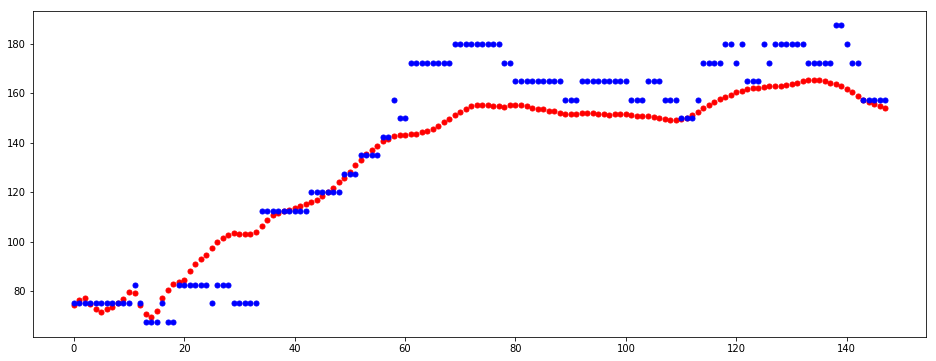

In [311]:
plt.figure(figsize=(16,6))
plt.plot(ref0['BPM0'], 'r.', ms=10)
plt.plot(calculated_bpm, 'b.', ms=10)

In [141]:
#Evaluate()

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 